# Unrequired


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import os
from torch.utils.data import DataLoader,Dataset
from PIL import Image
from torchvision.transforms import v2
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import random

In [ ]:
import os
from torch.utils.data import DataLoader,Dataset
from PIL import Image
from torchvision.transforms import v2
import numpy as np

class CustomImageDataset(Dataset):
    def __init__(self, train_dir, label_dir, transform=None):
        self.train_dir = train_dir
        self.label_dir = label_dir
        self.transform = transform
        self.train_image_paths = [os.path.join(train_dir, filename) for filename in os.listdir(train_dir)]
        self.label_image_paths = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]

    def __len__(self):
        return len(self.train_image_paths)

    def __getitem__(self, idx):
        train_image_path = self.train_image_paths[idx]
        label_image_path = self.label_image_paths[idx]

        train_image = Image.open(train_image_path)
        label_image = Image.open(label_image_path)
        # train_image = (np.asarray(train_image)/255.0)
        # label_image = (np.asarray(label_image)/255.0)

        if self.transform:
            train_image = self.transform(train_image)
            label_image = self.transform(label_image)


        return train_image, label_image

def load_data(train_path, label_path):
    data_transforms = v2.Compose([
        v2.Resize(size=(80,120 )),
        #v2.RandomCrop(size=(32, 32)),
        v2.ToTensor(),
        #v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    custom_dataset = CustomImageDataset(
        train_dir=train_path,
        label_dir=label_path,
        transform=data_transforms
    )

    data_loader = DataLoader(
        dataset=custom_dataset,
        batch_size=1,
        num_workers=1,
        shuffle=True
    )
    return data_loader

In [ ]:
# Specify the paths to your training and label image directories
train_data_dir = '/content/drive/MyDrive/Data_for_training'
label_data_dir = '/content/drive/MyDrive/Labels_for_training'

# Load the data using the load_data function
data_loader = load_data(train_data_dir, label_data_dir)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
def preprocess(img):
    red= img[:,0,:,:]
    green= img[:,1,:,:]
    blue= img[:,2,:,:]

    # blank_canvas = torch.zeros_like(red)
    # RG = torch.stack([red,green,blank_canvas],dim=0).unsqueeze(0)
    # RB = torch.stack([red,blank_canvas,blue],dim=0).unsqueeze(0)
    # GB = torch.stack([blank_canvas,green,blue],dim=0).unsqueeze(0)

    RG = torch.cat([red,green],dim=0).unsqueeze(0)
    RB = torch.cat([red,blue],dim=0).unsqueeze(0)
    GB = torch.cat([green,blue],dim=0).unsqueeze(0)
    #print(RG.shape)

    return RG,RB,GB
def get_input(test):
  inp=[]
  for i in test:
    ans = torch.cat(preprocess(i.unsqueeze(0)),dim=1)
    inp.append(ans)

  model_inp = torch.cat(inp,dim=0)
  return model_inp

In [ ]:
test = torch.rand(1,3,64,64)
ans = get_input(test)
ans.size()

torch.Size([1, 6, 64, 64])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Check for GPU Availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CCN(nn.Module):
    def __init__(self):
        super(CCN, self).__init__()

        # Output Layers
        self.output = nn.Conv2d(64, 6, kernel_size=3, stride=1, padding=1, bias=True)

    def Conv_BN_Relu(self, inp):
        return nn.Sequential(
            nn.Conv2d(
                inp,
                64,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=True
            ),
            nn.BatchNorm2d(64),
            nn.ReLU()
        ).cuda()

    def forward(self, x):
        layer_1 = self.Conv_BN_Relu(x.size(1))(x)
        layer_2 = self.Conv_BN_Relu(layer_1.size(1))(layer_1)
        layer_3 = self.Conv_BN_Relu(layer_2.size(1))(layer_2)
        layer_4 = self.Conv_BN_Relu(layer_3.size(1))(layer_3)
        layer_5 = self.Conv_BN_Relu(layer_4.size(1))(layer_4)

        cat_1 = torch.cat([layer_5,layer_4],dim=1)  # You can't use 'torch.cat' here
        layer_6 = self.Conv_BN_Relu(cat_1.size(1))(cat_1)

        cat_2 = torch.cat([layer_6,layer_3],dim=1)  # You can't use 'torch.cat' here
        layer_7 = self.Conv_BN_Relu(cat_2.size(1))(cat_2)

        cat_3 = torch.cat([layer_7,layer_2],dim=1)  # You can't use 'torch.cat' here
        layer_8 = self.Conv_BN_Relu(cat_3.size(1))(cat_3)

        cat_4 = torch.cat([layer_8 , layer_1],dim=1)  # You can't use 'torch.cat' here
        layer_9 = self.Conv_BN_Relu(cat_4.size(1))(cat_4)
        layer_10 = self.Conv_BN_Relu(layer_9.size(1))(layer_9)

        return self.output(layer_10)

# Initialize the model and move it to the GPU
test_model = CCN().to(device)


def color_relevance_loss(im_pre,im_nor):

        # Extract channels P and Q from enhanced and normal images
        tot_loss =0
        for enhanced_images, normal_images in zip(im_pre, im_nor):

                P_enhanced = enhanced_images[ :,0, :, :]  # Assuming channel 0 for P, adjust as needed
                Q_enhanced = enhanced_images[:,1, :, :]  # Assuming channel 1 for Q, adjust as needed

                P_normal = normal_images[:,0, :, :]  # Assuming channel 0 for P, adjust as needed
                Q_normal = normal_images[ :,1, :, :]  # Assuming channel 1 for Q, adjust as needed

                # Reshape P and Q to be 2D matrices
                N = P_enhanced.size(1) * P_enhanced.size(2)  # N = H x W
                P_enhanced = P_enhanced.view(-1, N)
                Q_enhanced = Q_enhanced.view(-1, N)
                P_normal = P_normal.view(-1, N)
                Q_normal = Q_normal.view(-1, N)

                # Compute the channel relevance map X for both normal and enhanced images
                X_enhanced = calculate_channel_relevance(P_enhanced, Q_enhanced)
                X_normal =calculate_channel_relevance(P_normal, Q_normal)

                # Compute the loss as the absolute difference between X in normal and enhanced images
                l = torch.sum(torch.abs(X_normal - X_enhanced))
                tot_loss+=l

        return tot_loss

def calculate_channel_relevance(P, Q):
        # Compute the correlation matrix X
        X = torch.mm(P, Q.t())

        # Apply softmax to calculate the channel relevance map
        X = F.softmax(X, dim=-1)

        return X






# Define the optimizer and loss function
optimizer = torch.optim.Adam(test_model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Assuming you have a DataLoader named 'data_loader'
for epoch in range(50):
    avg_loss = 0
    for data in data_loader:
        input_img, label_img = data  # Unpack the data

        input_img = get_input(input_img)
        label_img = get_input(label_img)

        input_img = input_img.to(torch.device('cuda'))
        label_img = label_img.to(torch.device('cuda'))



        model_output = test_model(input_img)


        loss_1 = criterion(input_img,model_output)#torch.norm(torch.sum(torch.abs(label_img - model_output)), p=1)
        loss_2 = torch.mean(torch.abs(torch.angle(label_img) - torch.angle(model_output)))
        loss_3 =color_relevance_loss([model_output[0:2],model_output[2:4],model_output[4:6]],[label_img[0:2],label_img[2:4],label_img[4:6]])
        loss = loss_1 + loss_2+loss_3
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()


    print(f'Epoch: {epoch + 1}, Average CCN loss: {avg_loss/len(data_loader)}')


Epoch: 1, Average CCN loss: 1.9415653703113398
Epoch: 2, Average CCN loss: 1.7794478056331475
Epoch: 3, Average CCN loss: 1.7327601138088438
Epoch: 4, Average CCN loss: 1.789613359545668
Epoch: 5, Average CCN loss: 1.7958768967125152
Epoch: 6, Average CCN loss: 1.7314026300277976
Epoch: 7, Average CCN loss: 1.828819613903761
Epoch: 8, Average CCN loss: 1.7635755966934892
Epoch: 9, Average CCN loss: 1.7954248101347023
Epoch: 10, Average CCN loss: 1.7463259578579002
Epoch: 11, Average CCN loss: 1.7720717805127302
Epoch: 12, Average CCN loss: 1.7561653366519345
Epoch: 13, Average CCN loss: 1.7645149738010433
Epoch: 14, Average CCN loss: 1.9142554213603338
Epoch: 15, Average CCN loss: 1.7614948896898164
Epoch: 16, Average CCN loss: 1.8405197610457738
Epoch: 17, Average CCN loss: 1.824597696090738
Epoch: 18, Average CCN loss: 1.7134473727809059
Epoch: 19, Average CCN loss: 1.7889070038994153
Epoch: 20, Average CCN loss: 1.8164561746021113
Epoch: 21, Average CCN loss: 1.730185640272167
Epoch

# DCE

In [ ]:
%cd /content/Zero-DCE/Zero-DCE_code

/content/Zero-DCE/Zero-DCE_code


In [ ]:
!python lowlight_test.py

data/test_data/LIME/6.bmp
0.1818993091583252
data/test_data/LIME/5.bmp
0.011644363403320312
data/test_data/LIME/9.bmp
0.006789207458496094
data/test_data/LIME/8.bmp
0.006338596343994141
data/test_data/LIME/10.bmp
0.008977890014648438
data/test_data/LIME/7.bmp
0.008466243743896484
data/test_data/LIME/3.bmp
0.006411552429199219
data/test_data/LIME/2.bmp
0.008001327514648438
data/test_data/LIME/4.bmp
0.006839752197265625
data/test_data/LIME/1.bmp
0.006280422210693359
data/test_data/DICM/48.jpg
0.010323524475097656
data/test_data/DICM/2.JPG
0.015061140060424805
data/test_data/DICM/56.jpg
0.00791168212890625
data/test_data/DICM/38.jpg
0.00689697265625
data/test_data/DICM/61.jpg
0.006724834442138672
data/test_data/DICM/54.jpg
0.0010750293731689453
data/test_data/DICM/8.JPG
Traceback (most recent call last):
  File "/content/Zero-DCE/Zero-DCE_code/lowlight_test.py", line 59, in <module>
    lowlight(image)
  File "/content/Zero-DCE/Zero-DCE_code/lowlight_test.py", line 36, in lowlight
    _,e

In [ ]:
def preprocess(img):
    red= img[0][0,:,:]
    green= img[0][1,:,:]
    blue= img[0][2,:,:]

    # blank_canvas = torch.zeros_like(red)
    # RG = torch.stack([red,green,blank_canvas],dim=0).unsqueeze(0)
    # RB = torch.stack([red,blank_canvas,blue],dim=0).unsqueeze(0)
    # GB = torch.stack([blank_canvas,green,blue],dim=0).unsqueeze(0)

    RG = torch.stack([red,green],dim=0).unsqueeze(0)
    RB = torch.stack([red,blue],dim=0).unsqueeze(0)
    GB = torch.stack([green,blue],dim=0).unsqueeze(0)
    #print(RG.shape)

    return RG,RB,GB

In [ ]:
def color_relevance_loss(im_pre,im_nor):

        # Extract channels P and Q from enhanced and normal images
        tot_loss =0
        for enhanced_images, normal_images in zip(im_pre, im_nor):

                P_enhanced = enhanced_images[ 0, :, :]  # Assuming channel 0 for P, adjust as needed
                Q_enhanced = enhanced_images[1, :, :]  # Assuming channel 1 for Q, adjust as needed

                P_normal = normal_images[0, :, :]  # Assuming channel 0 for P, adjust as needed
                Q_normal = normal_images[ 1, :, :]  # Assuming channel 1 for Q, adjust as needed

                # Reshape P and Q to be 2D matrices
                N = P_enhanced.size(0) * P_enhanced.size(1)  # N = H x W
                P_enhanced = P_enhanced.view(-1, N)
                Q_enhanced = Q_enhanced.view(-1, N)
                P_normal = P_normal.view(-1, N)
                Q_normal = Q_normal.view(-1, N)

                # Compute the channel relevance map X for both normal and enhanced images
                X_enhanced = calculate_channel_relevance(P_enhanced, Q_enhanced)
                X_normal =calculate_channel_relevance(P_normal, Q_normal)

                # Compute the loss as the absolute difference between X in normal and enhanced images
                loss = torch.abs(X_normal - X_enhanced)
                tot_loss+=loss

        return tot_loss

def calculate_channel_relevance(P, Q):
        # Compute the correlation matrix X
        X = torch.mm(P, Q.t())

        # Apply softmax to calculate the channel relevance map
        X = F.softmax(X, dim=-1)

        return X



In [ ]:
test_model.train()

optimizer = torch.optim.Adam(test_model.parameters(),lr=0.001)
l= torch.nn.MSELoss()
for i in range(100):
    avg_los =0
    for data in data_loader:
        label_img = torch.cat(preprocess(data[1]),dim=0).cuda()
        input_img = torch.cat(preprocess(data[0]),dim=0).cuda()
        # input_img= data[0].to(device)
        # label_img= data[1].to(device)
        # label_img,_,_ =preprocess(data[1])
        # RG,_,_ = preprocess(data[0])
        #label_img.shape


        model_output = test_model(input_img)
        # print(model_output.shape)
        # print(label_img.shape)



        loss_1 = torch.norm(torch.sum(torch.abs(label_img- model_output)),p=1)
        loss_2 =torch.mean(torch.abs(torch.angle(label_img) - torch.angle(model_output)))
        loss_3 = color_relevance_loss(model_output,label_img)
        loss=loss_1+loss_2+loss_3
        # loss = l(model_output,RG)
        optimizer.zero_grad()
        loss.backward()

        #torch.nn.utils.clip_grad_norm(test_model.parameters(),1)

        optimizer.step()

        avg_los +=loss.item()

    print(f'Epoch: {i+1} Average CCN loss: {avg_los}')

RuntimeError: ignored

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [ ]:
# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Flatten and normalize the pixel values
X_train = X_train.reshape(-1, 32 * 32 * 3).astype('float32') / 255.0
X_test = X_test.reshape(-1, 32 * 32 * 3).astype('float32') / 255.0

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


170498071/170498071 [==============================] - 12s 0us/step


In [ ]:
# Create an MLP model using TensorFlow (Keras)
model_relu = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32 * 32 * 3,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])


model_leaky_relu = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32 * 32 * 3,)),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(128,activation='leaky_relu'),
    tf.keras.layers.Dense(64,activation='leaky_relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])



In [ ]:
# Compile the model
model_relu.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_leaky_relu.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_relu = model_relu.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), verbose=2)


Epoch 1/100
1250/1250 - 10s - loss: 1.8914 - accuracy: 0.3088 - val_loss: 1.7587 - val_accuracy: 0.3621 - 10s/epoch - 8ms/step
Epoch 2/100
1250/1250 - 4s - loss: 1.7157 - accuracy: 0.3812 - val_loss: 1.6557 - val_accuracy: 0.4037 - 4s/epoch - 3ms/step
Epoch 3/100
1250/1250 - 5s - loss: 1.6418 - accuracy: 0.4094 - val_loss: 1.6480 - val_accuracy: 0.4022 - 5s/epoch - 4ms/step
Epoch 4/100
1250/1250 - 4s - loss: 1.5935 - accuracy: 0.4273 - val_loss: 1.5989 - val_accuracy: 0.4239 - 4s/epoch - 4ms/step
Epoch 5/100
1250/1250 - 5s - loss: 1.5496 - accuracy: 0.4433 - val_loss: 1.5786 - val_accuracy: 0.4324 - 5s/epoch - 4ms/step
Epoch 6/100
1250/1250 - 5s - loss: 1.5146 - accuracy: 0.4561 - val_loss: 1.5488 - val_accuracy: 0.4469 - 5s/epoch - 4ms/step
Epoch 7/100


KeyboardInterrupt: ignored

In [ ]:
history_leaky_relu = model_leaky_relu.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), verbose=2)

Epoch 1/100
1250/1250 - 5s - loss: 1.9140 - accuracy: 0.3072 - val_loss: 1.7887 - val_accuracy: 0.3606 - 5s/epoch - 4ms/step
Epoch 2/100
1250/1250 - 8s - loss: 1.7359 - accuracy: 0.3744 - val_loss: 1.7022 - val_accuracy: 0.3809 - 8s/epoch - 6ms/step
Epoch 3/100
1250/1250 - 4s - loss: 1.6475 - accuracy: 0.4095 - val_loss: 1.6440 - val_accuracy: 0.4028 - 4s/epoch - 3ms/step
Epoch 4/100
1250/1250 - 4s - loss: 1.5915 - accuracy: 0.4326 - val_loss: 1.5874 - val_accuracy: 0.4357 - 4s/epoch - 3ms/step
Epoch 5/100
1250/1250 - 5s - loss: 1.5491 - accuracy: 0.4460 - val_loss: 1.5349 - val_accuracy: 0.4578 - 5s/epoch - 4ms/step
Epoch 6/100
1250/1250 - 4s - loss: 1.5151 - accuracy: 0.4587 - val_loss: 1.5329 - val_accuracy: 0.4516 - 4s/epoch - 3ms/step
Epoch 7/100
1250/1250 - 4s - loss: 1.4776 - accuracy: 0.4737 - val_loss: 1.5218 - val_accuracy: 0.4581 - 4s/epoch - 3ms/step
Epoch 8/100
1250/1250 - 4s - loss: 1.4529 - accuracy: 0.4833 - val_loss: 1.5238 - val_accuracy: 0.4566 - 4s/epoch - 3ms/step


In [ ]:
# Plot training history
plt.plot(history_relu.history['accuracy'], label='Training Accuracy')
plt.plot(history_relu.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History (CIFAR-10 Dataset) RELU')
plt.show()

In [ ]:
# Evaluate the model
y_pred = np.argmax(model_relu.predict(X_test), axis=-1)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

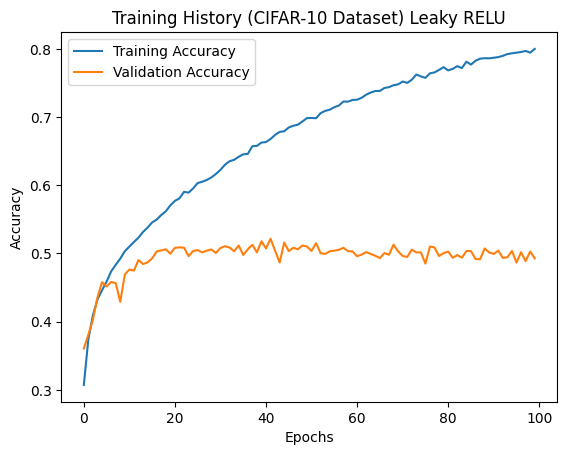

In [ ]:
# Plot training history
plt.plot(history_leaky_relu.history['accuracy'], label='Training Accuracy')
plt.plot(history_leaky_relu.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History (CIFAR-10 Dataset) Leaky RELU')
plt.show()

In [ ]:
# Evaluate the model
y_pred = np.argmax(model_leaky_relu.predict(X_test), axis=-1)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

313/313 [==============================] - 1s 3ms/step
Accuracy: 0.4912
Precision: 0.49398638557643765
Recall: 0.4912
F1 Score: 0.4874550692597535


Epoch 1/10
1250/1250 [==============================] - 10s 7ms/step - loss: 1.9346 - accuracy: 0.3083 - val_loss: 1.8372 - val_accuracy: 0.3364
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.7629 - accuracy: 0.3760 - val_loss: 1.7228 - val_accuracy: 0.3788
Epoch 3/10
1250/1250 [==============================] - 4s 3ms/step - loss: 1.6898 - accuracy: 0.3962 - val_loss: 1.6718 - val_accuracy: 0.3957
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.6570 - accuracy: 0.4092 - val_loss: 1.6638 - val_accuracy: 0.4048
Epoch 5/10
1250/1250 [==============================] - 4s 4ms/step - loss: 1.6293 - accuracy: 0.4208 - val_loss: 1.6556 - val_accuracy: 0.4147
Epoch 6/10
1250/1250 [==============================] - 4s 3ms/step - loss: 1.6062 - accuracy: 0.4294 - val_loss: 1.6293 - val_accuracy: 0.4233
Epoch 7/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.5907 - accuracy: 0.4331 - val_loss: 1.5999 - val_accuracy

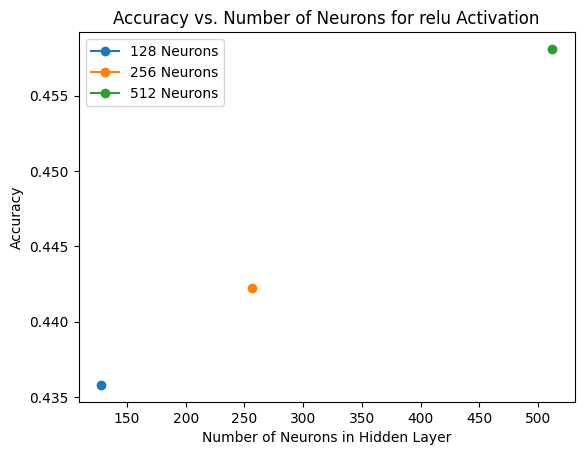

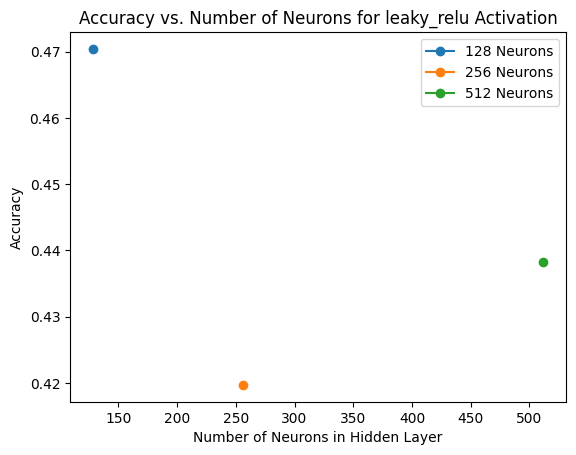

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

# Flatten the image data
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Split the dataset into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define a function to create and train an MLP model with different hidden layer sizes and activation functions
def create_train_mlp(hidden_layer_size, activation_function, num_epochs=10):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(hidden_layer_size, activation=activation_function),
        tf.keras.layers.Dense(10, activation='softmax')  # Output layer with 10 classes
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_epochs, verbose=1)

    return model, history

# Define a function to evaluate the model on the test set
def evaluate_model(model):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Experiment with different hidden layer sizes and activation functions
hidden_layer_sizes = [128, 256, 512]
activation_functions = ['relu', 'leaky_relu']

results = {'Activation Function': [], 'Hidden Layer Size': [], 'Accuracy': []}

for activation_function in activation_functions:
    for hidden_layer_size in hidden_layer_sizes:
        model, _ = create_train_mlp(hidden_layer_size, activation_function)
        accuracy, _, _, _ = evaluate_model(model)
        results['Activation Function'].append(activation_function)
        results['Hidden Layer Size'].append(hidden_layer_size)
        results['Accuracy'].append(accuracy)


# Plot the accuracy vs. the number of neurons graph
for activation_function in activation_functions:
    plt.figure()
    plt.title(f'Accuracy vs. Number of Neurons for {activation_function} Activation')
    plt.xlabel('Number of Neurons in Hidden Layer')
    plt.ylabel('Accuracy')
    subset = results['Activation Function']
    subset_hidden = results['Hidden Layer Size']
    for hidden_layer_size in hidden_layer_sizes:
        accuracies = [results['Accuracy'][i] for i in range(len(subset)) if subset[i] == activation_function and subset_hidden[i] == hidden_layer_size]
        plt.plot([hidden_layer_size for _ in range(len(accuracies))], accuracies, marker='o', label=f'{hidden_layer_size} Neurons')
    plt.legend(loc='best')
    plt.show()

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 50ms/step


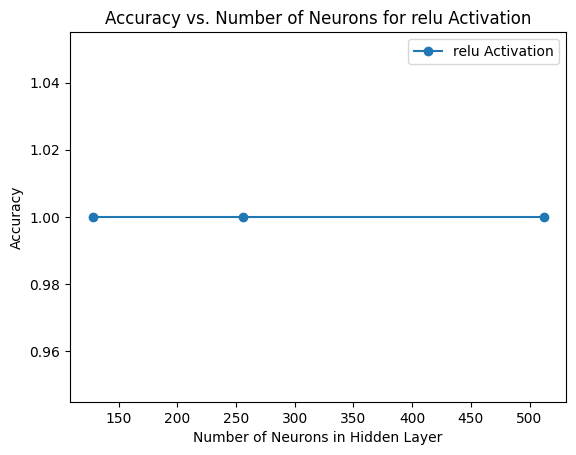

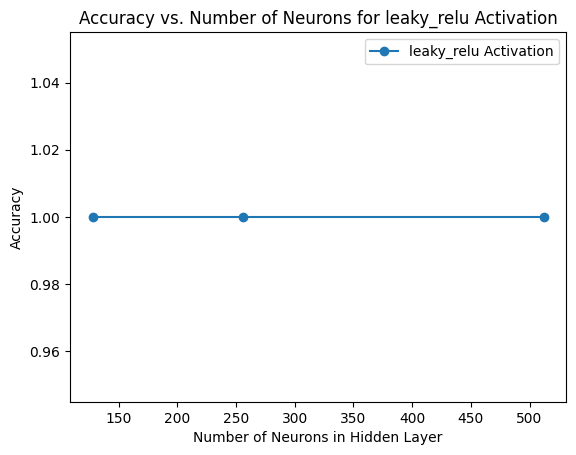

In [ ]:
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Load the IRIS dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define a function to create and train an MLP model with different hidden layer sizes and activation functions
def create_train_mlp(hidden_layer_size, activation_function, num_epochs=100):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(hidden_layer_size, activation=activation_function),
        tf.keras.layers.Dense(3, activation='softmax')  # Output layer with 3 classes
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=num_epochs, verbose=0)

    return model, history

# Define a function to evaluate the model on the test set
def evaluate_model(model):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Experiment with different hidden layer sizes and activation functions
hidden_layer_sizes = [128, 256, 512]
activation_functions = ['relu', 'leaky_relu']

results = {'Activation Function': [], 'Hidden Layer Size': [], 'Accuracy': []}

for activation_function in activation_functions:
    for hidden_layer_size in hidden_layer_sizes:
        model, _ = create_train_mlp(hidden_layer_size, activation_function)
        accuracy, _, _, _ = evaluate_model(model)
        results['Activation Function'].append(activation_function)
        results['Hidden Layer Size'].append(hidden_layer_size)
        results['Accuracy'].append(accuracy)

# Create separate lists for each activation function
activation_results = {activation_function: {'Hidden Layer Size': [], 'Accuracy': []} for activation_function in activation_functions}

for activation_function in activation_functions:
    subset = results['Activation Function']
    for hidden_layer_size in hidden_layer_sizes:
        accuracies = [results['Accuracy'][i] for i in range(len(subset)) if subset[i] == activation_function and results['Hidden Layer Size'][i] == hidden_layer_size]
        activation_results[activation_function]['Hidden Layer Size'].append(hidden_layer_size)
        activation_results[activation_function]['Accuracy'].append(np.mean(accuracies))

# Plot the accuracy vs. the number of neurons graph for each activation function
for activation_function in activation_functions:
    plt.figure()
    plt.title(f'Accuracy vs. Number of Neurons for {activation_function} Activation')
    plt.xlabel('Number of Neurons in Hidden Layer')
    plt.ylabel('Accuracy')
    plt.plot(activation_results[activation_function]['Hidden Layer Size'], activation_results[activation_function]['Accuracy'], marker='o')
    plt.legend([f'{activation_function} Activation'], loc='best')
    plt.show()



# CCFN Starts


In [1]:
!git clone https://github.com/fleventy-5/implementatin_project.git

Cloning into 'implementatin_project'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 13 (delta 0), reused 13 (delta 0), pack-reused 0
Receiving objects: 100% (13/13), 56.52 KiB | 7.06 MiB/s, done.


In [2]:
%cd /content/implementatin_project

/content/implementatin_project


In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from model.model import *
from utils.utils import *
from utils.dataset import *
from loss.loss import *

In [5]:
def display_image(image):
    # Convert the image tensor to a NumPy array
    image = image.squeeze(0)
    image = image.cpu().detach().numpy()

    # Transpose the image to channel, height, width
    image = image.transpose(1, 2, 0)

    # Normalize the image values to be between 0 and 1
    image = (image - image.min()) / (image.max() - image.min())

    # Display the image
    plt.imshow(image)
    plt.show()


In [6]:
import os
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision.transforms import transforms
import numpy as np

class CustomImageDataset2(Dataset):
    def __init__(self, train_dir, label_dir, transform=None):
        self.train_dir = train_dir
        self.label_dir = label_dir
        self.transform = transform

        # Get file paths for train and label images and sort them
        self.train_image_paths = sorted([os.path.join(train_dir, filename) for filename in os.listdir(train_dir)])
        self.label_image_paths = sorted([os.path.join(label_dir, filename) for filename in os.listdir(label_dir)])

    def __len__(self):
        return len(self.train_image_paths)

    def __getitem__(self, idx):
        train_image_path = self.train_image_paths[idx]
        label_image_path = self.label_image_paths[idx]

        train_image = Image.open(train_image_path)
        label_image = Image.open(label_image_path)

        if self.transform:
            train_image = self.transform(train_image)
            label_image = self.transform(label_image)

        return train_image, label_image

def load_data_V2(train_path, label_path):
    data_transforms = transforms.Compose([
        transforms.Resize(size=(240, 360)),
        # Add more transformations if needed
        transforms.ToTensor(),
    ])

    custom_dataset = CustomImageDataset2(
        train_dir=train_path,
        label_dir=label_path,
        transform=data_transforms
    )

    data_loader = DataLoader(
        dataset=custom_dataset,
        batch_size=32,
        num_workers=1
        # shuffle=True
    )
    return data_loader


In [7]:
train_data_dir = '/content/drive/MyDrive/Data_for_training'
label_data_dir = '/content/drive/MyDrive/Labels_for_training'
# Specify the paths to your training and label image directories


# Load the data using the load_data function
data_loader = load_data_V2(train_data_dir,label_data_dir)


In [8]:
# # Get an image from the data loader
# image,label = next(iter(data_loader))

# # Display the image
# display_image(image)
# display_image(label)


In [9]:
def get_img(inputs):
    batch_size = inputs[0].size(0)

    r1 = inputs[0][:, 0, :, :].unsqueeze(1)
    g1 = inputs[0][:, 1, :, :].unsqueeze(1)
    b1 = inputs[1][:, 1, :, :].unsqueeze(1)

    r2 = inputs[1][:, 0, :, :].unsqueeze(1)
    g2 = inputs[2][:, 0, :, :].unsqueeze(1)
    b2 = inputs[2][:, 1, :, :].unsqueeze(1)

    img1 = torch.cat([r1, g1, b1], dim=1)
    img2 = torch.cat([r2, g2, b2], dim=1)

    return img1, img2

In [10]:
l= torch.nn.MSELoss()

In [11]:
def ccn_loss(label_img,output):
    loss_1 = l(output[0],label_img[0])+ l(output[1],label_img[1])+ l(output[2],label_img[2])
    loss_2 =torch.mean(torch.abs(torch.angle(label_img[0]) - torch.angle(output[0])))+torch.mean(torch.abs(torch.angle(label_img[1]) - torch.angle(output[1])))+torch.mean(torch.abs(torch.angle(label_img[2]) - torch.angle(output[2])))
    loss_3 = color_relevance_loss(output,label_img)


    return loss_1+0.7*loss_2+0.1*loss_3

In [ ]:
def train_CCN(ccn_model,ccn_optimizer,dataloader,epoch=2):
    best_loss = float('inf')
    for i in range(epoch):
        loss_ccn = 0
        loss_mfn = 0
        loss_den = 0
        for data in dataloader:

            input_img,input_label =data
            ccn_input = preprocess(input_img)
            ccn_labels = preprocess(input_label)

            ccn_input = [_data.cuda() for _data in ccn_input]
            ccn_labels = [_label.cuda() for _label in ccn_labels]

            ccn_output = ccn_model(ccn_input)


            loss_1 = ccn_loss(ccn_labels,ccn_output)
            ccn_optimizer.zero_grad()
            loss_1.backward()
            ccn_optimizer.step()
            loss_ccn +=loss_1.item()


            # im1,im2 = get_img(ccn_output)

            # mfn_input = im1*im2
            # mfn_output = mfn_model(mfn_input)

            # mfn_optimizer.zero_grad()
            # loss_2 = l(mfn_output,input_label)
            # loss_2.backward(retain_graph=True)
            # mfn_optimizer.step()




            # den_inp = arithmetic_mean_filter(mfn_output)
            # den_output = den_model(den_inp)

            # den_optimzer.zero_grad()
            # loss_3 = loss_1.get_den_loss(den_output,input_label)
            # loss_3.backward(retain_graph=True)
            # den_optimzer.step()


            loss_ccn = loss_1.item()
            # loss_mfn = loss_2.item()
            # loss_den = loss_3.item()






        #print(f'Epoch: {i+1} Average DEN loss: {loss_den/len(dataloader)}')
        #print(f'Epoch: {i+1} Average MFN loss: {loss_mfn/len(dataloader)}')
        print(f'Epoch: {i+1} Average CCN loss: {loss_ccn/len(data_loader)}')
        if (loss_ccn/len(data_loader)) < best_loss:
          best_loss = (loss_ccn/len(data_loader))

          # Save the model
          torch.save(ccn_model.state_dict(), '/content/drive/MyDrive/weight/ccn_model.pth')


ccn = CCN_Model().to(device)
ccn_optim = torch.optim.Adam(ccn.parameters(),lr=0.001)

train_CCN(ccn,ccn_optim,data_loader,50)

Epoch: 1 Average CCN loss: 0.018748853355646133
Epoch: 2 Average CCN loss: 0.00793273871143659
Epoch: 3 Average CCN loss: 0.00829780971010526
Epoch: 4 Average CCN loss: 0.004285671437780063
Epoch: 5 Average CCN loss: 0.0028492299218972525
Epoch: 6 Average CCN loss: 0.0021970270512004695
Epoch: 7 Average CCN loss: 0.0039511459569136305
Epoch: 8 Average CCN loss: 0.00350735771159331
Epoch: 9 Average CCN loss: 0.0032666123782595
Epoch: 10 Average CCN loss: 0.003194732591509819
Epoch: 11 Average CCN loss: 0.0037225360671679177
Epoch: 12 Average CCN loss: 0.003886775424083074
Epoch: 13 Average CCN loss: 0.004995701213677724
Epoch: 14 Average CCN loss: 0.00359508798768123
Epoch: 15 Average CCN loss: 0.0020979211355249086
Epoch: 16 Average CCN loss: 0.0021543544717133045
Epoch: 17 Average CCN loss: 0.0018973348972698052
Epoch: 18 Average CCN loss: 0.0020456655571858087
Epoch: 19 Average CCN loss: 0.003736989883085092
Epoch: 20 Average CCN loss: 0.004855632161100705
Epoch: 21 Average CCN loss:

In [ ]:
def train_MFN(mfn_model,mfn_optimizer,dataloader,epoch=2):
    for i in range(epoch):
        loss_ccn = 0
        loss_mfn = 0
        loss_den = 0
        for data in dataloader:

            input_img,input_label =data
            ccn_input = preprocess(input_img)
            ccn_input = [_data.cuda() for _data in ccn_input]
            input_label = input_label.to(device)
            # ccn_labels = preprocess(input_label)

            # ccn_output = ccn_model(ccn_input)


            # loss_1 = ccn_loss(ccn_labels,ccn_output)
            # ccn_optimizer.zero_grad()
            # loss_1.backward()
            # ccn_optimizer.step()
            # loss_ccn +=loss_1.item()
            ccn.eval()
            with torch.no_grad():
                ccn_output = ccn(ccn_input)



            im1,im2 = get_img(ccn_output)

            mfn_input = im1*im2
            mfn_output = mfn_model(mfn_input)

            mfn_optimizer.zero_grad()
            loss_2 = l(mfn_output,input_label)
            loss_2.backward(retain_graph=True)
            mfn_optimizer.step()




            # den_inp = arithmetic_mean_filter(mfn_output)
            # den_output = den_model(den_inp)

            # den_optimzer.zero_grad()
            # loss_3 = loss_1.get_den_loss(den_output,input_label)
            # loss_3.backward(retain_graph=True)
            # den_optimzer.step()


            #loss_ccn = loss_1.item()
            loss_mfn = loss_2.item()
            # loss_den = loss_3.item()





        #print(f'Epoch: {i+1} Average DEN loss: {loss_den/len(dataloader)}')
        print(f'Epoch: {i+1} Average MFN loss: {loss_mfn/len(dataloader)}')
        #print(f'Epoch: {i+1} Average CCN loss: {loss_ccn/len(data_loader)}')



mfn = MFN().to(device)
mfn.train()
mfn_optim = torch.optim.Adam(mfn.parameters(),lr=0.001)
train_MFN(mfn,mfn_optim,data_loader,50)